## Classifier  Finetuning
LLM 微调本书介绍了两种微调方法：
分类任务微调
指令微调
在本章我们主要讨论分类任务微调，例如spam/ham分类问题


In [85]:
#加载数据集
# Listing 6.1 Downloading and unzipping the dataset
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

In [86]:


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    with urllib.request.urlopen(url) as response:          #A
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:        #B
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)          #C
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


#A 下载数据集
#B 解压数据集
#C 为解压的数据集文件设置.csv文件扩展名

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [87]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
print(df)

#A 在 Jupyter Notebook 中可以直接渲染数据，或者用 print(df) 命令显示数据内容

     Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [88]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [89]:
#在这里我们展示使用相同大小的数据集，处理不平衡的方法超出本文的内容
#下面是将df类型的数据集进行裁剪到相同的747条训练数据
def create_balanced_dataset(df):
    num_spam = df[df["Label"]== "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balance_df = pd.concat([ham_subset,df[df['Label']=="spam"]])
    return balance_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [90]:
#将训练集的label改为1或0
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [91]:
#.sample函数 用于随机抽样 第一个参数frac是随机打乱后的抽样比例
#.reset_index将drop设置为true的目的是讲索引重置从0开始

#验证集和测试集的区别
验证集是用来帮助模型调节超参数
测试集是来测试模型的性能的
超参数是模型在训练之前由用户手动设置的参数，它们不会在训练过程中通过数据自动调整。超参数主要影响模型的训练方式和结构，而不是直接参与模型对输入数据的预测。

In [93]:
#创建一个函数用来分离训练集，验证集和测试集
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)     #A
    train_end = int(len(df) * train_frac)                               #B
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]                                           #C
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)  #D
print(len(train_df))
print(len(validation_df))
print(len(test_df))


#A 将整个 DataFrame 随机打乱
#B 计算数据分割的索引
#C 分割 DataFrame
#D 测试集默认大小为 0.2（即剩余部分）

1045
149
300


In [94]:
#此外，我们将数据集保存为 CSV 文件，以便后续复用：
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
#index=none就是将to_csv设置为默认设置，不将pd 的index作为第一列进行存储

在第2章中，我们使用滑动窗口技术生成了大小一致的文本块，并将它们分组成批次，以提高模型训练的效率。每个文本块都作为一个独立的训练实例。
然而，本章中我们使用的垃圾短信数据集包含长度不一的文本消息。为了像第 2 章中的文本块那样对这些消息进行批处理，我们有两种处理方式：
将所有消息截断至数据集或批次中最短消息的长度。
将所有消息填充到数据集或批次中最长消息的长度。
方案一的计算成本较低，但如果较短的消息远小于平均长度或最长消息长度，可能会导致显著的信息损失，从而降低模型的性能。因此，我们选择方案二，以完整保留所有消息的内容。
为实现方案二，我们需要将所有消息填充到与数据集中最长消息相同的长度，对所有较短的消息添加填充 token。为此，我们使用 "<|endoftext|>"

In [96]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [97]:
#实现一个Dataset 用于定义训练集的数据加载和处理
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [                                  #B
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [                                      #C
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    def __getitem__(self,index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long))
    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

# max_length 参数可以由用户指定如果没有指定那么将会同个函数_longest_encoded_length计算进行赋值

In [98]:
train_dataset = SpamDataset(csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer)
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [99]:
#实例化datasetloader
# Listing 6.5 Creating PyTorch data loaders
from torch.utils.data import DataLoader

num_workers = 0                  #A
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

#A 此设置可确保与大多数计算机兼容

In [100]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
#注意这里只是打印了最后一个批次input 和 target
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


#使用与训练的权重初始化模型

In [102]:
#初始化配置
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
print(BASE_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}


In [103]:
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [104]:
import torch.nn as nn
#封装归一化层
# Listing 4.2 A layer normalization class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
#esp是一个小常数 防止出现除以0的错误
#unbiased 这个参数设置是为了防止样本过少导致归一化过小，
#当设置为true时方差为n-1个样本的，而设置为false的时候就为n个样本
#LLM的样本数量较大所以不需要设置贝塞尔校正
# 激活层 GELU函数 与 RELU相似
# Listing 4.3 An implementation of the GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
# FeedForward网络模块 
# Listing 4.4 A feed forward neural network module
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
#上面的MultiHeadAttention是将并行的结果进行拼接，而接下来
# 的这种是将结果进行乘积也就是将张量结果组合在一起
# Listing 3.5 An efficient multi-head attention class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads                        #A
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)                   #B
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
             torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )


    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)                                      #C
        queries = self.W_query(x)                                 #C
        values = self.W_value(x)                                  #C

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #D
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)   #D
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) #D

        keys = keys.transpose(1, 2)                               #E
        queries = queries.transpose(1, 2)                         #E
        values = values.transpose(1, 2)                           #E

        attn_scores = queries @ keys.transpose(2, 3)              #F
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #G

        attn_scores.masked_fill_(mask_bool, -torch.inf)           #H

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)     #I

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  #J
        context_vec = self.out_proj(context_vec)                  #K
        return context_vec


#A 将投影维度缩小，以匹配期望的输出维度
#B 使用线性层组合头部输出
#C 张量形状：(b, num_tokens, d_out)
#D 我们通过添加 num_heads 维度来隐式地拆分矩阵。然后展开最后一个维度，使其形状从 (b, num_tokens, d_out) 转换为 (b, num_tokens, num_heads, head_dim)
#E 将张量的形状从 (b, num_tokens, num_heads, head_dim) 转置为 (b, num_heads, num_tokens, head_dim)
#F 对每个注意力头进行点积运算
#G 掩码被截断到 token 的数量
#H 使用掩码填充注意力分数
#I 张量形状：（b, num_tokens, n_heads, head_dim）
#J 将多个注意力头的输出结果合并，其中输出维度 self.d_out 等于注意力头数 self.num_heads 与每个头的维度 self.head_dim 的乘积
#K 添加一个可选的线性投影层
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x                                          #A
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back
        shortcut = x                                          #B
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut                                       #C
        return x


#A 注意力模块中的快捷连接
#B 前馈网络模块中的快捷链接
#C 将原始输入加回到输出中
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))      #A
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

 #A 设备设置将根据输入数据所在的位置选择在 CPU 或 GPU 上训练模型

In [105]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [106]:
#将params字典中的权重加载到我们的模型当中
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])



#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

In [107]:
print(CHOOSE_MODEL)
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
print(model_size)

gpt2-small (124M)
124M


In [108]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [109]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [110]:
# Listing 4.8 A function for the GPT model to generate text
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                                   #C
        probas = torch.softmax(logits, dim=-1)                      #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)       #E
        #其实softmax最大概率值与源向量组最大值的索引是一样实际上softmax是多余的操作
        idx = torch.cat((idx, idx_next), dim=1)                     #F

    return idx
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [111]:
#验证初始化的模型是否能够生成连贯的文本
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you eatenitage eaten eaten eaten eaten eaten eaten eaten Aster Done eaten Aster recountsitage


In [82]:
#在没有微调之前我们先看看这个模型是否能够对垃圾信息进行分类
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' petty petty petty petty petty petty petty petty Luthor petty Transgender petty petty petty petty Transgender petty Luthor petty Transgender Luthor Transgender Transgender


# 添加分类头
只需要修改Linear output layer就行了，原来是一个in 768dim out 50257dim的线性层，每个神经元代表一个单词的概率，而二分类只需要out 2dim代表spam和ham的概率。

In [136]:
#替换输出层
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)
#这个新的输出层 model.out_head 的 requires_grad 属性默认为 True，意味着它是模型训练过程中唯一会被更新的层。

# 层冻结
GPT模型在进行分类微调的时候，需要打开输出层和最后一个transformer block的梯度计算，这种技术叫做层冻结。
如果打开所有的梯度会破坏原有的预训练的功能，减小训练的计算开销以及微调的数据集过小防止过拟合。在 GPT 这样的深度模型中，模型的浅层（靠近输入端的层）主要负责学习语言的低层次特征（如词法、语法、短程依赖等），而靠近输出端的层则更负责学习高级语义信息和任务相关的特定特征。

In [138]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [142]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)  # shape: (batch_size, num_tokens, num_classes)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-0.6458, -0.7218],
         [-0.8805, -0.3163],
         [-1.1334, -0.7274],
         [-1.3001, -0.9750]]])
Outputs dimensions: torch.Size([1, 4, 2])


# 我们只需要提取出最后一行token作为预测标签的输出
我们知道在attention score的矩阵中，最后一行token将会聚合前面所有token的信息，具有一定的全局语义，能够反映整个输入序列的特征。只关注最后一个token也可以减少分类决策中的冗余，减少其他token带来的不必要的噪声，而且模型更加容易收敛。

# 模型评估计算loss函数


In [144]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-1.3001, -0.9750]])


In [148]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)
label = torch.argmax(probas)
print("Class label:", label.item())

tensor([[0.4194, 0.5806]])
Class label: 1


In [150]:
#也可以不应用softmax进行分类
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [152]:
#计算预测正确的比例
# Listing 6.8 Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]                   #A
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

#A 最后一个输出 token 的 logits 值

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 51.25%


#因为calc_accuracy_loader函数无法微分，所以我们无法通过反向传播来降低梯度所以我们还是使用cross entropy作为损失函数 
我们非常明显的看到上面的代码存在布尔运算离散计算 是无法微分的

In [156]:
#计算单个批次的损失函数
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [158]:
#计算多个批次的损失函数，计算总损失后取平均值即可
# Listing 6.9 Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                      #A
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [162]:
with torch.no_grad():                           #B
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.745
Validation loss: 0.705
Test loss: 0.720


# 通过梯度下降loss函数，来微调模型

In [166]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
    
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):#eval_iter 每次评估loss使用多少批数据
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()                                      #A

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                          #B
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                #C
            optimizer.step()                               #D
            examples_seen += input_batch.shape[0]          #E
            global_step += 1


            if global_step % eval_freq == 0:               #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(             #G
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


#A 设置模型为训练模式
#B 重置上一批次的损失梯度
#C 计算损失梯度
#D 使用损失梯度更新模型权重
#E 更改逻辑：跟踪样本数量而非 token 数量
#F 可选评估步骤
#G 每个 epoch 后计算准确率

In [170]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5,weight_decay=0.1)
#weight_decay 正则化权重衰减
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.018, Val loss 0.942
Ep 1 (Step 000050): Train loss 0.305, Val loss 0.260
Ep 1 (Step 000100): Train loss 0.132, Val loss 0.117
Training accuracy: 92.50% | Validation accuracy: 90.00%
Ep 2 (Step 000150): Train loss 0.141, Val loss 0.061
Ep 2 (Step 000200): Train loss 0.042, Val loss 0.046
Ep 2 (Step 000250): Train loss 0.042, Val loss 0.151
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.120, Val loss 0.217
Ep 3 (Step 000350): Train loss 0.017, Val loss 0.060
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.006, Val loss 0.064
Ep 4 (Step 000450): Train loss 0.030, Val loss 0.197
Ep 4 (Step 000500): Train loss 0.002, Val loss 0.534
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.017, Val loss 0.072
Ep 5 (Step 000600): Train loss 0.000, Val loss 0.087
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training completed in 72.9

In [174]:
# Listing 6.11 Plotting the classification loss
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


#A 绘制训练轮次与训练和验证损失的变化图
#B 创建一个新的 x 轴，用于显示已处理样本数
#C 调整布局以留出空间

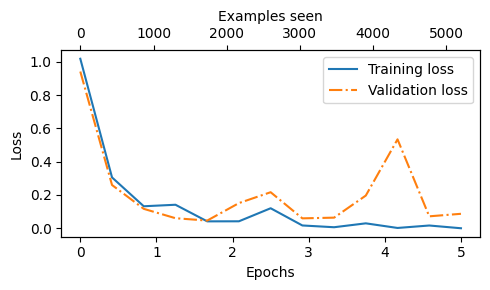

In [176]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

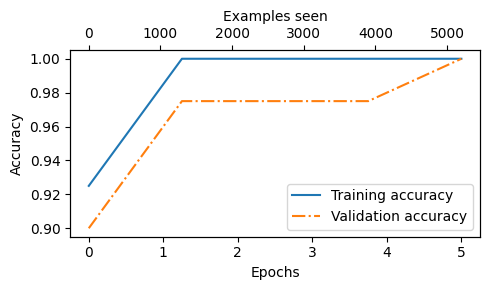

In [178]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")


In [180]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 99.33%
Test accuracy: 97.33%


In [188]:
#将模型用于垃圾短信分类
# Listing 6.12 Using the model to classify new texts
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)                                   #A
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]    #B

    input_ids += [pad_token_id] * (max_length - len(input_ids))          #C
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)   #D

    with torch.no_grad():                                                #E
        logits = model(input_tensor)[:, -1, :]                           #F
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"                #G


#A 准备模型输入
#B 截断过长序列
#C 填充序列至最长长度
#D 增加批次维度
#E 关闭梯度跟踪，进行模型推理
#F 获取最后一个输出 token 的 logits
#G 返回分类结果

In [190]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [192]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [194]:
torch.save(model.state_dict(), "review_classifier.pth")